Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 183344.1875 - val_loss: 171130.8281
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 183179.1875 - val_loss: 170950.2500
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 182956.7031 - val_loss: 170769.7188
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 182781.3281 - val_loss: 170584.1562
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 182572.3125 - val_loss: 170390.3438
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 182291.5469 - val_loss: 170190.6562
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 182252.1719 - val_loss: 170004.2812
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 182085.3750 - val_loss: 169821.8281
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 181768.7031 - val_loss: 169629.9688
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 181613.0781 - val_loss: 169427.6562
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 1

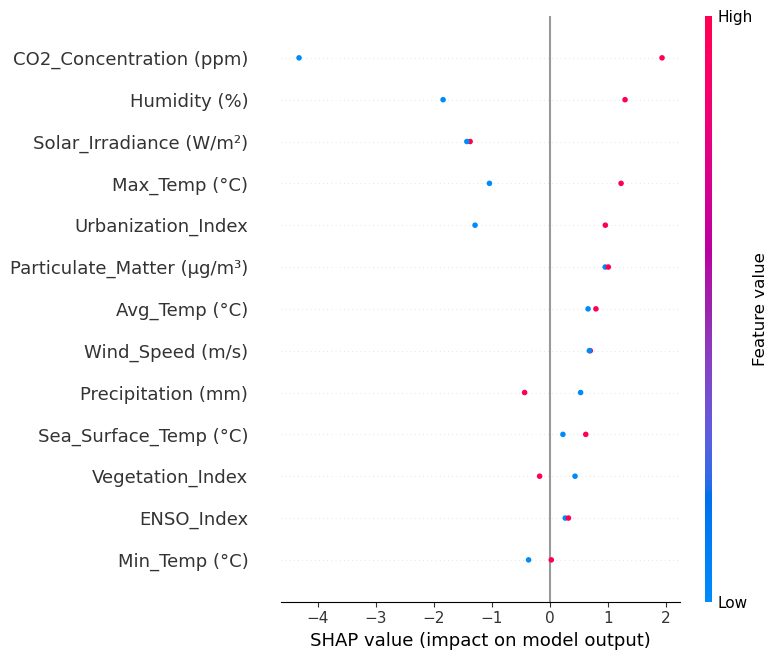

Model training complete. Geospatial visualization saved.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import shap
import google.generativeai as genai
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configure Gemini API
genai.configure(api_key="MY_API_KEY")  # Replace with your actual API key

def get_gemini_insights(prompt):
    model = genai.GenerativeModel("gemini-1.5-pro")  # Updated model name
    response = model.generate_content(prompt)
    return response.text if hasattr(response, 'text') else "No insights available"

# Load Dataset
df = pd.read_csv("climate_change_dataset.csv")  # Replace with actual dataset path

# Data Preprocessing
df.dropna(inplace=True)  # Handle missing values

# Feature Selection
features = ['Avg_Temp (°C)', 'Max_Temp (°C)', 'Min_Temp (°C)', 'Precipitation (mm)',
            'Humidity (%)', 'Wind_Speed (m/s)', 'Solar_Irradiance (W/m²)', 'CO2_Concentration (ppm)',
            'Urbanization_Index', 'Vegetation_Index', 'ENSO_Index', 'Particulate_Matter (µg/m³)',
            'Sea_Surface_Temp (°C)']

target = 'CO2_Concentration (ppm)'  # Targeting CO2 concentration as the main output

# Convert object columns to numeric
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle any remaining missing values after conversion
df.dropna(inplace=True)

X = df[features]
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ensemble Models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, enable_categorical=False)
xgb.fit(X_train, y_train)

# Train LSTM Model
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test))

# Evaluate Models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score:", r2_score(y_test, y_pred))

print("Random Forest Results:")
evaluate_model(rf, X_test, y_test)
print("XGBoost Results:")
evaluate_model(xgb, X_test, y_test)

# Gemini AI Insights
gemini_prompt = "Provide AI-driven climate change mitigation strategies based on current CO2 trends."
print("Gemini AI Insights:", get_gemini_insights(gemini_prompt))

# Explainable AI (SHAP Analysis)
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Visualization - Geospatial Mapping
map = folium.Map(location=[0, 0], zoom_start=2)
for index, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['CO2_Concentration (ppm)'] / 10,
        color='red' if row['CO2_Concentration (ppm)'] > 400 else 'green',
        fill=True,
        fill_color='red' if row['CO2_Concentration (ppm)'] > 400 else 'green'
    ).add_to(map)
map.save("climate_risk_map.html")

print("Model training complete. Geospatial visualization saved.")